<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> CC3104 - Aprendizaje por Refuerzo 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 8:</strong> Deep Reinforcement Learning</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
      </ul>
    </td>
  </tr>
</table>

Repositorio: https://github.com/LINDAINES213/Lab8-RL.git

Librerías

In [8]:
import math
import random
import collections
import time
from collections import deque
from typing import Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

## Inciso 1 — Ambiente - CartPole-v1

In [9]:
ENV_ID = "CartPole-v1"
RENDER_DURING_TRAINING = False

env = gym.make(ENV_ID, render_mode="human") if RENDER_DURING_TRAINING else gym.make(ENV_ID)
env.reset(seed=SEED)
obsDim = env.observation_space.shape[0]
nActions = env.action_space.n
print(f"Ambiente: {ENV_ID} — estado={obsDim}, acciones={nActions}")

Ambiente: CartPole-v1 — estado=4, acciones=2


## Inciso 2 — Algoritmo DQN

In [10]:
GAMMA = 0.99
LR = 0.0001
BATCH_SIZE = 64
BUFFER_CAPACITY = 10_000
TARGET_UPDATE_FREQ = 1000

EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY_STEPS = 20_000

MAX_EPISODES = 500
MAX_STEPS_PER_EPISODE = 1000

class DQN(nn.Module):
    def __init__(self, inputDim: int, outputDim: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inputDim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, outputDim),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

policyNet = DQN(obsDim, nActions)
targetNet = DQN(obsDim, nActions)
targetNet.load_state_dict(policyNet.state_dict())
targetNet.eval()

optimizer = optim.Adam(policyNet.parameters(), lr=LR)
mseLoss = nn.MSELoss()

def epsilonByStep(step: int) -> float:
    frac = min(1.0, step / EPS_DECAY_STEPS)
    return EPS_START + (EPS_END - EPS_START) * frac

def selectAction(state: np.ndarray, globalStep: int) -> Tuple[int, float]:
    eps = epsilonByStep(globalStep)
    if random.random() < eps:
        return env.action_space.sample(), eps
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q = policyNet(s)
        a = int(torch.argmax(q, dim=1).item())
        return a, eps

Transition = collections.namedtuple("Transition", ["state","action","reward","nextState","done"])

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)
    def push(self, state, action, reward, nextState, done):
        self.buffer.append(Transition(state, action, reward, nextState, done))
    def sample(self, batchSize: int):
        batch = random.sample(self.buffer, batchSize)
        states = torch.tensor(np.array([t.state for t in batch]), dtype=torch.float32)
        actions = torch.tensor([t.action for t in batch], dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32).unsqueeze(-1)
        nextStates = torch.tensor(np.array([t.nextState for t in batch]), dtype=torch.float32)
        dones = torch.tensor([t.done for t in batch], dtype=torch.float32).unsqueeze(-1)
        return states, actions, rewards, nextStates, dones
    def __len__(self):
        return len(self.buffer)

replayBuffer = ReplayBuffer(BUFFER_CAPACITY)

def dqnUpdate() -> float:
    if len(replayBuffer) < BATCH_SIZE:
        return 0.0
    states, actions, rewards, nextStates, dones = replayBuffer.sample(BATCH_SIZE)
    qValues = policyNet(states).gather(1, actions)
    with torch.no_grad():
        maxNextQ = targetNet(nextStates).max(dim=1, keepdim=True)[0]
        target = rewards + (1.0 - dones) * GAMMA * maxNextQ
    loss = mseLoss(qValues, target)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policyNet.parameters(), max_norm=10.0)
    optimizer.step()
    return float(loss.item())

## Inciso 3 — Consideraciones técnicas
En esta implementación se usaron tres elementos importantes para mejorar el entrenamiento. El primero es la target network, una copia de la red principal que se actualiza cada cierto número de pasos para evitar que los valores objetivo cambien demasiado rápido y el aprendizaje se vuelva inestable. También se aplicó gradient clipping para limitar el valor máximo de los gradientes y evitar explosiones que podrían afectar la convergencia. Por último, se usó una política ε-greedy con decaimiento, que empieza explorando mucho el entorno (ε alto) y va reduciendo el valor de ε con el tiempo para aprovechar lo aprendido. Estos tres aspectos ayudan a que el entrenamiento sea más estable y efectivo..

## Inciso 4 — Entrenamiento

In [11]:
EPISODES_TO_TRAIN = 600
SOLVED_SCORE = 475.0
LOG_EVERY = 10

rewardHistory, avg100History, epsHistory, lossHistory = [], [], [], []
recentRewards = deque(maxlen=100)

globalStep = 0
bestAvg100 = -float("inf")
startTime = time.time()

for ep in range(1, EPISODES_TO_TRAIN + 1):
    state, _ = env.reset(seed=SEED + ep)
    epReward = 0.0
    epLosses = []
    for t in range(MAX_STEPS_PER_EPISODE):
        action, eps = selectAction(state, globalStep)
        nextState, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replayBuffer.push(state, action, reward, nextState, done)
        state = nextState
        epReward += reward
        globalStep += 1
        loss = dqnUpdate()
        if loss:
            epLosses.append(loss)
        if globalStep % TARGET_UPDATE_FREQ == 0:
            targetNet.load_state_dict(policyNet.state_dict())
        if done:
            break
    rewardHistory.append(epReward)
    recentRewards.append(epReward)
    avg100 = float(np.mean(recentRewards))
    avg100History.append(avg100)
    epsHistory.append(eps)
    if epLosses:
        lossHistory.append(np.mean(epLosses))
    if avg100 > bestAvg100:
        bestAvg100 = avg100
    if ep % LOG_EVERY == 0 or ep == 1:
        print(f"Ep {ep:4d} | R: {epReward:6.1f} | ε: {eps:5.3f} | avg100: {avg100:6.1f} | buffer: {len(replayBuffer):5d} | step: {globalStep}")
    if bestAvg100 >= SOLVED_SCORE and len(recentRewards) == recentRewards.maxlen:
        print(f"\n✅ Resuelto: avg100={bestAvg100:.1f} (≥ {SOLVED_SCORE}) en ep={ep}.")
        break

elapsed = time.time() - startTime
print(f"\nEntrenamiento finalizado en {ep} episodios, tiempo: {elapsed:.1f}s. Mejor avg100: {bestAvg100:.1f}")

Ep    1 | R:   35.0 | ε: 0.998 | avg100:   35.0 | buffer:    35 | step: 35
Ep   10 | R:   13.0 | ε: 0.991 | avg100:   18.9 | buffer:   189 | step: 189
Ep   20 | R:   15.0 | ε: 0.983 | avg100:   17.6 | buffer:   352 | step: 352
Ep   30 | R:   19.0 | ε: 0.972 | avg100:   18.7 | buffer:   562 | step: 562
Ep   40 | R:    9.0 | ε: 0.962 | avg100:   19.4 | buffer:   775 | step: 775
Ep   50 | R:   36.0 | ε: 0.951 | avg100:   19.9 | buffer:   993 | step: 993
Ep   60 | R:   35.0 | ε: 0.941 | avg100:   19.9 | buffer:  1194 | step: 1194
Ep   70 | R:   22.0 | ε: 0.932 | avg100:   19.7 | buffer:  1379 | step: 1379
Ep   80 | R:   14.0 | ε: 0.920 | avg100:   20.2 | buffer:  1616 | step: 1616
Ep   90 | R:   19.0 | ε: 0.910 | avg100:   20.2 | buffer:  1814 | step: 1814
Ep  100 | R:   24.0 | ε: 0.899 | avg100:   20.4 | buffer:  2035 | step: 2035
Ep  110 | R:   46.0 | ε: 0.886 | avg100:   21.2 | buffer:  2313 | step: 2313
Ep  120 | R:   34.0 | ε: 0.869 | avg100:   23.1 | buffer:  2657 | step: 2657
Ep  13

## Inciso 5 — Visualización

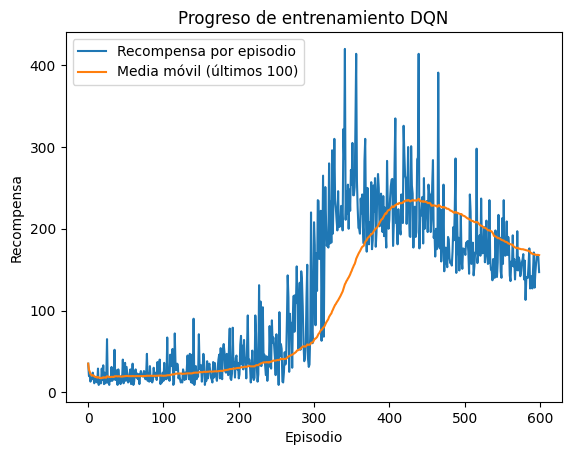

In [12]:
plt.figure()
plt.plot(rewardHistory, label="Recompensa por episodio")
plt.plot(avg100History, label="Media móvil (últimos 100)")
plt.title("Progreso de entrenamiento DQN")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()
plt.show()

La gráfica muestra cómo el rendimiento del agente DQN mejora progresivamente a lo largo del entrenamiento. Al inicio, las recompensas son bajas por la alta exploración, pero alrededor del episodio 300 se observa un incremento notable, alcanzando cerca de 200 pasos en promedio. Después del episodio 400 aparecen oscilaciones y una ligera caída, señal de que el aprendizaje no fue completamente estable. Esto indica que el agente aprendió una política funcional, aunque aún lejos del óptimo (~475 pasos), posiblemente por la configuración actual de hiperparámetros. Ajustarlos podría mejorar la estabilidad y el rendimiento.

## Inciso 6 — Evaluación (ε=0) y video

In [20]:
torch.save(policyNet.state_dict(), "dqn_cartpole.pt")
evalNet = DQN(obsDim, nActions)
evalNet.load_state_dict(torch.load("dqn_cartpole.pt", map_location="cpu"))
evalNet.eval()
print("✅ Modelo cargado para evaluación")

def greedyAction(net: nn.Module, state: np.ndarray) -> int:
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        return int(torch.argmax(net(s), dim=1).item())

N_EVAL_EPISODES = 10
evalEnv = gym.make(ENV_ID)
rewardsEval = []
for i in range(N_EVAL_EPISODES):
    s, _ = evalEnv.reset(seed=SEED + 2000 + i)
    done = False
    epR = 0.0
    while not done:
        a = greedyAction(evalNet, s)
        s, r, term, trun, _ = evalEnv.step(a)
        epR += r
        done = term or trun
    rewardsEval.append(epR)
evalEnv.close()

print("📊 Evaluación (ε=0):")
print("  Recompensas por episodio:", rewardsEval)
print(f"  Promedio: {np.mean(rewardsEval):.2f}")
print(f"  Mínimo:   {np.min(rewardsEval):.2f}")
print(f"  Máximo:   {np.max(rewardsEval):.2f}")
print(f"  Desv. Std: {np.std(rewardsEval):.2f}")

renderEnv = gym.make(ENV_ID, render_mode="human")
s, _ = renderEnv.reset(seed=SEED + 999)
done = False
epR = 0.0
print("\n🎬 Ejecutando episodio con renderizado...")
while not done:
    a = greedyAction(evalNet, s)
    s, r, term, trun, _ = renderEnv.step(a)
    epR += r
    done = term or trun
renderEnv.close()
print(f"✅ Episodio completado. Recompensa total: {epR}")

✅ Modelo cargado para evaluación
📊 Evaluación (ε=0):
  Recompensas por episodio: [154.0, 160.0, 135.0, 173.0, 140.0, 163.0, 183.0, 145.0, 147.0, 138.0]
  Promedio: 153.80
  Mínimo:   135.00
  Máximo:   183.00
  Desv. Std: 15.04

🎬 Ejecutando episodio con renderizado...
✅ Episodio completado. Recompensa total: 185.0


# Discusión de resultados
En la evaluación sin exploración (ε = 0), el agente alcanzó un promedio de 153.8 pasos por episodio, con un mínimo de 135, un máximo de 183 y una desviación estándar de 15.04. El episodio grabado llegó a 185 pasos, lo que evidencia que el agente aprendió una política capaz de mantener el poste en equilibrio durante un número considerable de pasos, superando ampliamente el comportamiento aleatorio. Sin embargo, el rendimiento aún está por debajo del nivel que se considera como entorno resuelto (≈475 pasos), lo que indica que la política no es completamente estable ni óptima.

La variabilidad observada refleja que el aprendizaje no terminó de converger, algo común en implementaciones básicas de DQN. Ajustes en la tasa de aprendizaje, el tamaño del batch, el ritmo de decaimiento de ε o la incorporación de variantes como Double DQN podrían ayudar a mejorar el desempeño. Aun con estas limitaciones, los resultados muestran un progreso significativo respecto al inicio del entrenamiento y son coherentes con la tendencia observada en la gráfica, evidenciando que el agente logró aprender estrategias útiles dentro del entorno CartPole.